# CS 20 : TensorFlow for Deep Learning Research
## Lecture 04 : Eager execution
### Custon training basics
* Reference
    + https://www.tensorflow.org/tutorials/eager/custom_training?hl=ko

### Setup

In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

tf.enable_eager_execution()

print(tf.__version__)

1.12.0


### Variables
Tensors in TensorFlow are immutable stateless objects. Machine learning models, however, need to have changing state: as your model trains, the same code to compute predictions should behave differently over time (hopefully with a lower loss!). To represent this state which needs to change over the course of your computation, you can choose to rely on the fact that Python is a stateful programming language:

In [2]:
# Using python state
x = tf.zeros([10, 10])
x += 2  # This is equivalent to x = x + 2, which does not mutate the original
        # value of x
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


***TensorFlow, however, has stateful operations built in, and these are often more pleasant to use than low-level Python representations of your state.*** To represent weights in a model, for example, it's often convenient and efficient ***to use TensorFlow variables.*** 

***Computations using Variables are automatically traced when computing gradients***. For Variables representing embeddings TensorFlow will do sparse updates by default, which are more computation and memory efficient. Using Variables is also a way to quickly let a reader of your code know that this piece of state is mutable.

In [3]:
v = tf.Variable(1.0)
print(v)

# Re-assign the value
v.assign(3.0)
print(v)

# Use `v` in a TensorFlow operation like tf.square() and reassign
v.assign(tf.square(v))
print(v.numpy)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>
<bound method ResourceVariable.numpy of <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=9.0>>


### Example: Fitting a linear model
1. Define the model
2. Define a loss function
3. Obtain training data
4. Run through the training data and use "optimizer" to adjust the variables to fit the data

#### define model

In [4]:
class Model():
    def __init__(self):
        self.w = tf.Variable(tf.random_normal(shape = []))
        self.b = tf.Variable(0.)
        
    def __call__(self, x):
        return self.w * x + self.b
    
model = Model()

#### Define a loss function

In [5]:
def loss_fn(predicted_y, desired_y):
    return tf.reduce_mean(tf.square(predicted_y - desired_y))

In [6]:
# Obtain training data
true_w = 3.0
true_b = 2.0
num_examples = 1000

inputs  = tf.random_normal(shape=[num_examples])
noise   = tf.random_normal(shape=[num_examples])
outputs = inputs * true_w + true_b + noise

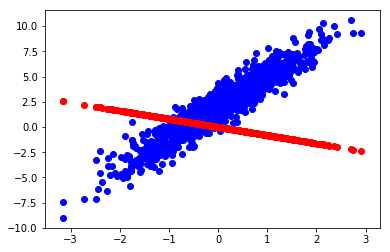

Current loss: 
18.592113


In [7]:
plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: '),
print(loss_fn(model(inputs), outputs).numpy())

#### Run through the training data and use "optimizer" to adjust the variables to fit the data

In [8]:
epochs = 10
batch_size = 64
learning_rate = .1

data = tf.data.Dataset.from_tensor_slices((inputs, outputs))
data = data.shuffle(500)
data = data.batch(batch_size = batch_size)

In [9]:
# When using tf.train, you read the document (https://www.tensorflow.org/guide/eager)  
w_hist = []
b_hist = []

for epoch in range(epochs):
    avg_loss = 0
    tr_step = 0
    for mb_x, mb_y in data:
        with tf.GradientTape() as tape:
            mb_yhat = model(mb_x)
            mb_loss = loss_fn(mb_yhat, mb_y)
        dw, db = tape.gradient(target = mb_loss, sources = [model.w, model.b])
        
        model.w.assign_sub(learning_rate * dw)
        model.b.assign_sub(learning_rate * db)
        tr_step += 1
        avg_loss += mb_loss
    else:
        w_hist.append(model.w.numpy())
        b_hist.append(model.b.numpy())
        avg_loss /= tr_step

    print('epoch: {:2}, w: {:.2f}, b: {:.2f}, mse_loss: {:.3f}'.format(epoch + 1, w_hist[-1],
                                                                       b_hist[-1], avg_loss))

epoch:  1, w: 2.79, b: 1.95, mse_loss: 4.200
epoch:  2, w: 3.03, b: 1.97, mse_loss: 0.998
epoch:  3, w: 2.95, b: 2.03, mse_loss: 0.982
epoch:  4, w: 2.96, b: 2.01, mse_loss: 0.979
epoch:  5, w: 3.00, b: 2.07, mse_loss: 0.987
epoch:  6, w: 2.98, b: 2.04, mse_loss: 0.987
epoch:  7, w: 2.99, b: 1.95, mse_loss: 0.988
epoch:  8, w: 3.02, b: 2.00, mse_loss: 0.980
epoch:  9, w: 3.02, b: 1.97, mse_loss: 0.985
epoch: 10, w: 2.98, b: 2.04, mse_loss: 0.984


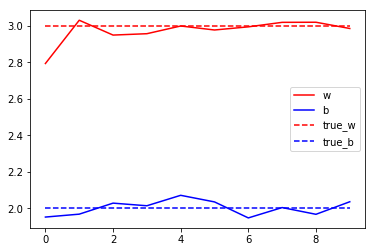

In [10]:
# Let's plot it all
plt.plot(range(epochs), w_hist, 'r',
         range(epochs), b_hist, 'b')
plt.plot([true_w] * len(range(epochs)), 'r--',
         [true_b] * len(range(epochs)), 'b--')
plt.legend(['w', 'b', 'true_w', 'true_b'])
plt.show()